In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

#Help function to use for easy submission for Kaggle competition
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
import pandas as pd
#Train sessions csv was compressed as it exceeded GitHub's 50MB threshold
train_data = pd.read_csv('data/train_sessions.csv.gz', compression='gzip')
test_data = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

#Soring the date to get more consistent CV results in the future
train_data["time1"] = pd.to_datetime(train_data["time1"])
train_data = train_data.sort_values('time1')

Let's start with checking and changing the types of the data and further preprocessing if needed

In [111]:
train_data.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [112]:
#The time columns types should be changed to timedata and site IDs will be changed to int as they represent site IDs
train_data.dtypes

site1              int64
time1     datetime64[ns]
site2            float64
time2             object
site3            float64
time3             object
site4            float64
time4             object
site5            float64
time5             object
site6            float64
time6             object
site7            float64
time7             object
site8            float64
time8             object
site9            float64
time9             object
site10           float64
time10            object
target             int64
dtype: object

In [113]:
#Let's create 2 lists, the first one will contain site column names and the second will have time column names
time_features = ['time' + str(i) for i in range(1, 11)]
site_features = ['site' + str(i) for i in range(1, 11)]

Before changing the sites and time features data types, we have to fill NA values

In [114]:
train_data["sites_visited"] = train_data[site_features].notna().sum(axis=1)
test_data["sites_visited"] = test_data[site_features].notna().sum(axis=1)

#For siteIDs NA values will be simply filled with 0
train_data[site_features] = train_data[site_features].fillna("").astype(str)
test_data[site_features]  = test_data[site_features].fillna("").astype(str)

#For time features values we will fill with the latest available timestamp in the row
train_data[time_features] = train_data[time_features].ffill(axis=1)
test_data[time_features] = test_data[time_features].ffill(axis=1)

#And now we can change the type of time features to a type that will be more easier to work with in pandas
for time in time_features:
    train_data[time] = pd.to_datetime(train_data[time], format="%Y-%m-%d %H:%M:%S")
    test_data[time] = pd.to_datetime(test_data[time], format="%Y-%m-%d %H:%M:%S")

y_train = train_data["target"]
X_train = train_data.drop(time_features + site_features + ["target"], axis=1)
X_test = test_data.drop(time_features + site_features, axis=1)

C:\Users\egorv\AppData\Local\Temp\ipykernel_7352\210854230.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[time_features] = train_data[time_features].ffill(axis=1)


I'll make a baseline model using only the siteIDs with the TFIdf approach

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [116]:
X_train_sites = train_data[site_features].astype(str).agg(" ".join, axis=1)
X_test_sites = test_data[site_features].astype(str).agg(" ".join, axis=1)

vectorizer = TfidfVectorizer(
    ngram_range=(1,5), max_features=100000,
    tokenizer=lambda s: s.split()
)

X_train_sites_vec_1 = vectorizer.fit_transform(X_train_sites)
X_test_sites_vec_1 = vectorizer.transform(X_test_sites)

c:\Users\egorv\anaconda3\envs\fastai_env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Now let's try some simple EDA<br>
Firstly I want to check what are the session times for everyone(except Alice) and only for Alice

In [117]:
import matplotlib.pyplot as plt

In [118]:
#Let's see the distribution of our target value
train_data.target.value_counts(normalize=True)
#The percentage of Alice session in the train data set is hardly 1%, so we will keep that in mind while initializing our logistic regression model

target
0    0.990941
1    0.009059
Name: proportion, dtype: float64

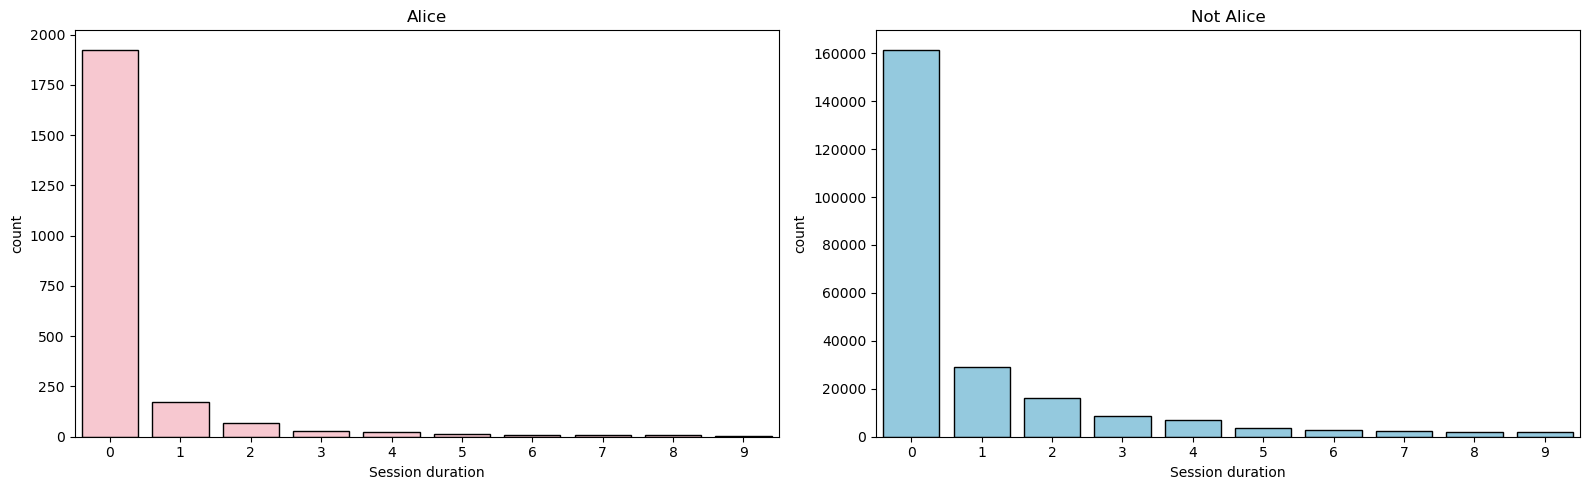

In [119]:
alice = train_data[train_data['target'] == 1]
not_alice = train_data[train_data['target'] == 0]

not_alice_time_delta = (not_alice['time10'] - not_alice['time1']).dt.total_seconds() / 60
alice_time_delta = (alice['time10'] - alice['time1']).dt.total_seconds() / 60
alice_short = alice_time_delta[alice_time_delta < 10].astype(int)
not_alice_short = not_alice_time_delta[not_alice_time_delta < 10].astype(int)

fig, ax = plt.subplots(1, 2, figsize=(16,5))

# Alice
sns.countplot(x=alice_short, ax=ax[0], color="pink", edgecolor="black")
ax[0].set_title("Alice")
ax[0].set_xlabel("Session duration")

# Others
sns.countplot(x=not_alice_short, ax=ax[1], color="skyblue", edgecolor="black")
ax[1].set_title("Not Alice")
ax[1].set_xlabel("Session duration")

plt.tight_layout()
plt.show()

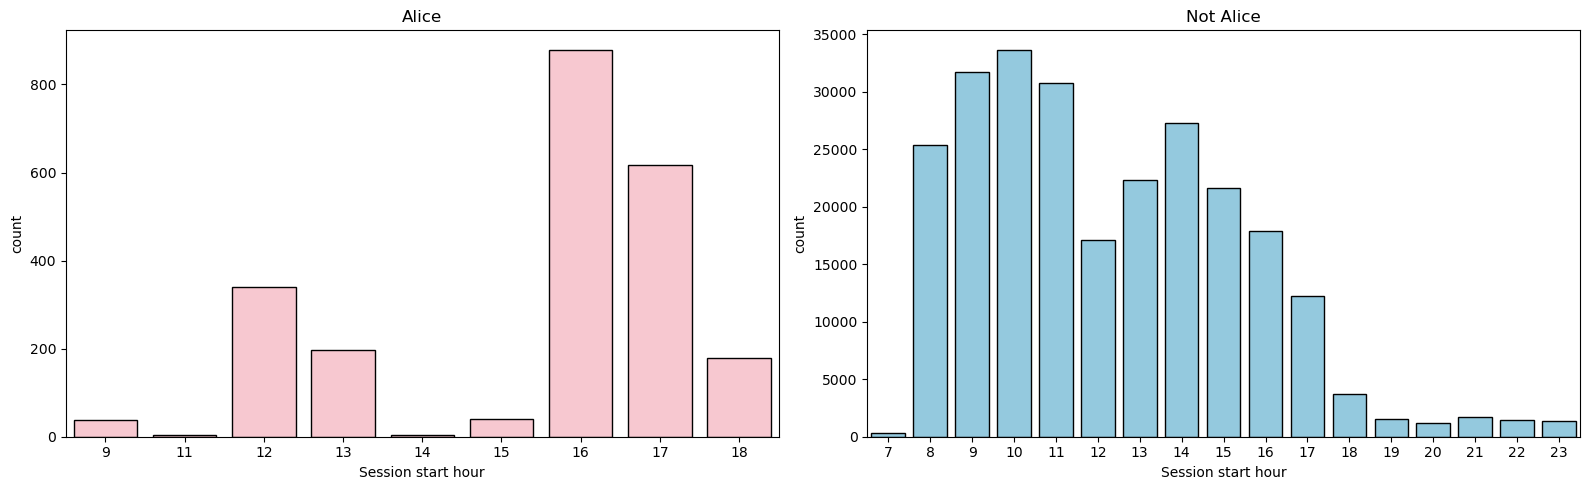

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

a_hour = alice["time1"].dt.hour
sns.countplot(x=a_hour, ax=ax[0], color="pink", edgecolor="black")
ax[0].set_title("Alice")
ax[0].set_xlabel("Session start hour")

na_hour = not_alice["time1"].dt.hour
sns.countplot(x=na_hour, ax=ax[1], color="skyblue", edgecolor="black")
ax[1].set_title("Not Alice")
ax[1].set_xlabel("Session start hour")

plt.tight_layout()
plt.show()

The last thing I want to check is how the start of the session by day of the week looks like for Alice and others

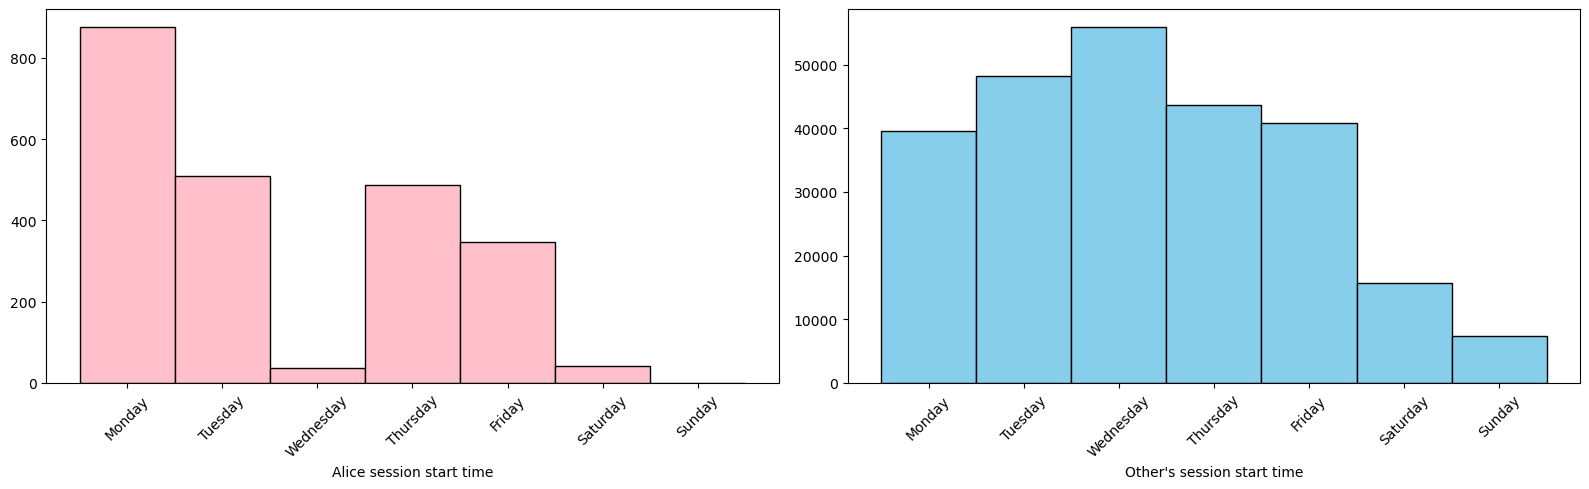

In [121]:
import numpy as np
import calendar

fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].hist(alice["time1"].dt.dayofweek, bins=np.arange(-0.5, 7.5, 1), color="pink", edgecolor="black")
ax[0].set_xlabel("Alice session start time")
ax[0].set_xticks(range(0, 7))
ax[0].set_xticklabels(list(calendar.day_name[i] for i in range(7)), rotation=45)

ax[1].hist(not_alice["time1"].dt.dayofweek, bins=np.arange(-0.5, 7.5, 1), color="skyblue", edgecolor="black")
ax[1].set_xlabel("Other's session start time")
ax[1].set_xticks(range(0, 7))
ax[1].set_xticklabels(list(calendar.day_name[i] for i in range(7)), rotation=45)

plt.tight_layout()
plt.show()

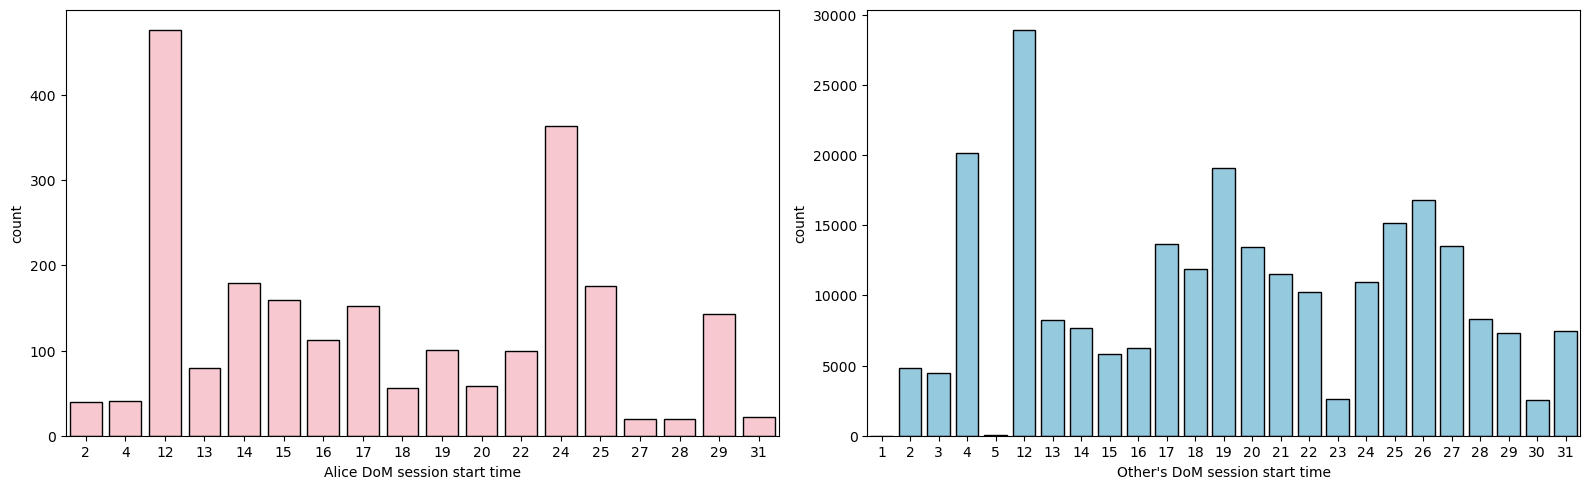

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

alice_dom = alice["time1"].dt.day.astype(int)
not_alice_dom = not_alice["time1"].dt.day.astype(int)

sns.countplot(x=alice_dom, ax=ax[0], color="pink", edgecolor="black")
ax[0].set_xlabel("Alice DoM session start time")

sns.countplot(x=not_alice_dom, ax=ax[1], color="skyblue", edgecolor="black")
ax[1].set_xlabel("Other's DoM session start time")


plt.tight_layout()
plt.show()

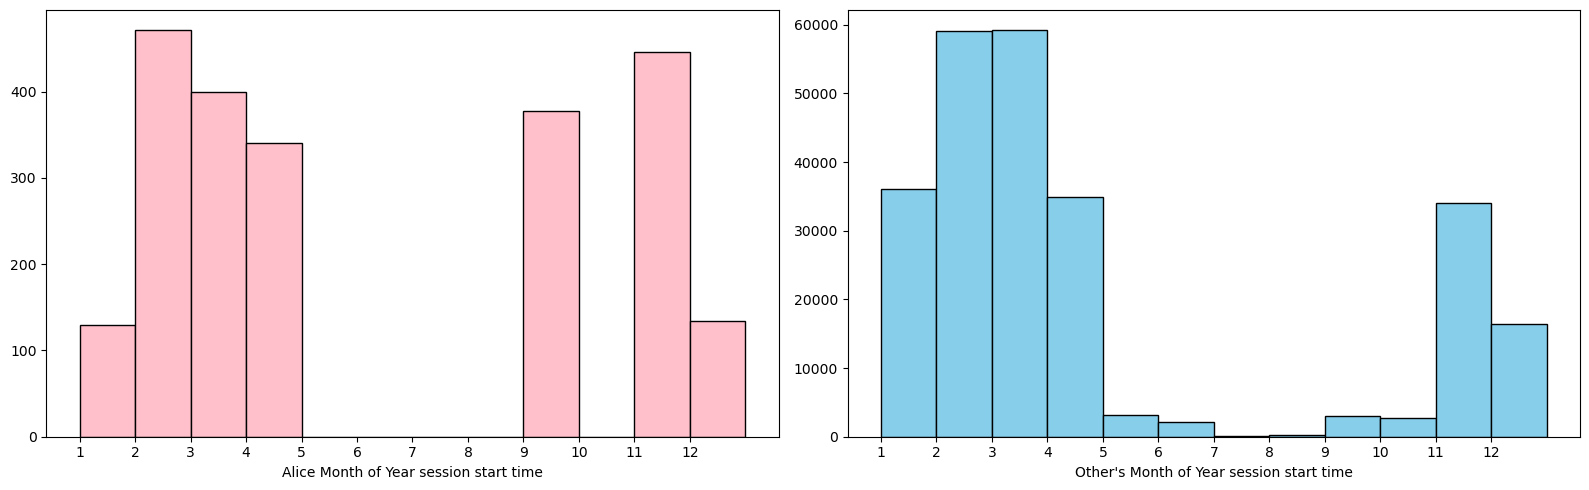

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].hist(alice["time1"].dt.month, bins=np.arange(1, 14, 1), color="pink", edgecolor="black")
ax[0].set_xlabel("Alice Month of Year session start time")
ax[0].set_xticks(range(1, 13))

ax[1].hist(not_alice["time1"].dt.month, bins=np.arange(1, 14, 1), color="skyblue", edgecolor="black")
ax[1].set_xlabel("Other's Month of Year session start time")
ax[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

We can notice that the session start time and duration could reflect user behavior patterns. To capture these we will create several features:
1. Time-of-day segments (early_morning, day, between_day_evening, evening, night) — to represent different user activity periods throughout the day, as user behavior may vary depending on the time.
2. Weekend indicator (wed_sat_sun) — to distinguish between weekday and weekend browsing habits.
3. Session duration — calculated as the time difference between session start and end, representing how long a user was active.
4. Sites visited — the number of unique sites visited during a session, indicating browsing intensity.

These features might help to identify differences between Alice and other users.

In [124]:
X_train["early_morning"] = ((train_data.time1.dt.hour >= 9) & (train_data.time1.dt.hour < 12)).astype(int)
X_train["day"] = ((train_data.time1.dt.hour >= 12) & (train_data.time1.dt.hour < 14)).astype(int)
X_train["between_day_evening"] = ((train_data.time1.dt.hour >= 14) & (train_data.time1.dt.hour < 16)).astype(int)
X_train["evening"] = ((train_data.time1.dt.hour >= 16) & (train_data.time1.dt.hour < 19)).astype(int)
X_train["night"] = ((train_data.time1.dt.hour >= 19) & (train_data.time1.dt.hour < 9)).astype(int)


X_test["early_morning"] = ((test_data.time1.dt.hour >= 9) & (test_data.time1.dt.hour < 12)).astype(int)
X_test["day"] = ((test_data.time1.dt.hour >= 12) & (test_data.time1.dt.hour < 14)).astype(int)
X_test["between_day_evening"] = ((test_data.time1.dt.hour >= 14) & (test_data.time1.dt.hour < 16)).astype(int)
X_test["evening"] = ((test_data.time1.dt.hour >= 16) & (test_data.time1.dt.hour < 19)).astype(int)
X_test["night"] = ((test_data.time1.dt.hour >= 19) & (test_data.time1.dt.hour < 9)).astype(int)

In [125]:
X_train["wed_sat_sun"] = train_data.time1.dt.dayofweek.isin([2, 5, 6]).astype(int)
X_test["wed_sat_sun"] = test_data.time1.dt.dayofweek.isin([2, 5, 6]).astype(int)


train_time = (train_data.time10 - train_data.time1).dt.total_seconds() / 60
test_time = (test_data.time10 - test_data.time1).dt.total_seconds() / 60
X_train["session_duration"] = train_time
X_test["session_duration"] = test_time

X_train["sites_visited"] = train_data["sites_visited"]
X_test["sites_visited"] = test_data["sites_visited"]

In [126]:
X_train.head()

,sites_visited,early_morning,day,between_day_evening,evening,night,wed_sat_sun,session_duration
session_id,,,,,,,,
21669,2,0,0,0,0,0,1,0.000000
54843,4,0,0,0,0,0,1,29.766667
77292,10,0,0,0,0,0,1,0.066667
114021,10,0,0,0,0,0,1,0.050000
146670,10,0,0,0,0,0,1,0.033333


Now I'll prepare the data for predictions

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

In [128]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_to_scale = ['session_duration', 'sites_visited']

# Fit only on session_duration sites_visited as they are the only continuous features in the dataset, the rest are binary features
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

scaled_X_train_temp = hstack([csr_matrix(X_train_scaled), X_train_sites_vec_1])
scaled_X_test_temp = hstack([csr_matrix(X_test_scaled), X_test_sites_vec_1])

In [129]:
#Lets initialize the baseline
logit1 = LogisticRegression(max_iter=3000, solver='liblinear', verbose=2, n_jobs=-1, random_state=1)

In [130]:
tscv = TimeSeriesSplit(n_splits=10)

This is our baseline

In [ ]:
logit_grid_ts_cv_scores = cross_val_score(logit1, scaled_X_train_temp, y_train, cv=tscv, scoring="roc_auc", n_jobs=-1)
print(logit_grid_ts_cv_scores.mean()) #~0.895

0.895061866437872


Now we will do some hyperparamethers tuning with the hope of getting better results

In [ ]:
# The model will be loaded from a pickle file so we will not have to wait for it to train

#  param_grid = {
#     "C": [0.1, 1, 10],
#     "penalty": ["l1", "l2"],
#     "class_weight": [None, "balanced"]
# }

# logit2 = LogisticRegression(solver="liblinear", max_iter=3000, random_state=1)

# grid = GridSearchCV(
#     estimator=logit2,
#     param_grid=param_grid,
#     scoring="roc_auc",
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

In [ ]:
# grid.fit(scaled_X_train_temp, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [138]:
import pickle

I'll save the model as pickle file so it will not have to be trained each time as it takes around 6 minutes on my PC

In [ ]:
# tuned_logit = grid.best_estimator_
# with open('pickle_objects/liblinear.pkl', 'wb') as f:
#     pickle.dump(tuned_logit, f)

In [143]:
with open('pickle_objects/liblinear.pkl', 'rb') as f:
    tuned_logit = pickle.load(f)

In [ ]:
ts_cv = cross_val_score(tuned_logit, scaled_X_train_temp, y_train, cv=tscv, scoring="roc_auc", n_jobs=-1)
#We can see a very slight improvement
print(ts_cv.mean()) #~0.899

0.8993636060272342


In [141]:
y_predict = tuned_logit.predict_proba(scaled_X_test_temp)[:,-1]
write_to_submission_file(y_predict, "liblinear1.csv") #ROC-AUC: 0.9445

So after we've added some features we've managed to get quite a good result on the validation set.